## DATASET INFORMATION

- The dataset used in this lab is SEED-IV which was available on link https://bcmi.sjtu.edu.cn/home/seed/seed-iv.html.

- The scenario of the experiment to collect the SEED-IV dataset is that each participant will be shown video clips. The content of these videos will be used to label the data captured by the process. Seventy-two film clips were carefully chosen by a preliminary study, which had the tendency to induce happiness, sadness, fear or neutral emotions.

- In SEED-IV dataset, there are total of 15 subjects participated in the experiment. For each participant, 3 sessions were performed on different days, and each session contained 24 trials. In one trial, the participant watched one of the film clips, while his or her EEG signals and eye movements were collected with the 62-channel ESI NeuroScan System and SMI eye-tracking glasses.

- The folder that can be downloaded for SEED-IV may contain some sub-folders and different type of signal. In this code, we mainly use raw EEG signal for analyzing. The "eeg_raw_data" folder contains the raw EEG signals of the 15 participants. The inner 3 folders named '1', '2' and '3' correspond to the 3 sessions. Each ".mat" file (named with {SubjectName}_{Date}.mat) in the folders stores a structure with fields named "cz_eeg1", "cz_eeg2", ... , "cz_eeg24", which correspond to the EEG signals recorded during the 24 trials. The architecture of one of the files is shown below.

- This process will only use 2 labels from this dataset which is neutral and happy. This action will make classification process into binary classification.

## IMPORTS AND CONFIGURATION

In [1]:
!pip install -r requirements.txt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import stft
import random

from loading_data import *
from CONSTANT import *

Using mps device


In [3]:
def set_seed(seed=42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

## Feature extraction

In [4]:
def number_fft(window_size):
    """Calculate the next power of 2 for FFT window size."""
    power = 0
    window_tmp = window_size - 1
    while(window_tmp != 1):
        power = power + 1
        window_tmp = int(window_tmp / 2)
    return pow(2,power +1)

def feature_extraction(input_data, stft_parameters=DEFAULT_STFT_PARAMETERS, label_num=0, fs=SAMPLING_FQ):
    """
    Extract STFT-based features from EEG data for one trial.
    """
    def square(x): return (np.abs(x))**2
    def decibels(x): return 10*np.log10(x)

    window_size = stft_parameters['window_size']
    window_shift = stft_parameters['window_shift']
    avg_window_size = stft_parameters['avg_filter_size']
    window_type = stft_parameters['window_type']

    feature_list = []
    nfft_size = number_fft(window_size)

    # Process all 62 channels
    for i in range(62):
        channel_feature_list = []

        # Compute STFT for this channel
        eeg_feq = stft(input_data[:, i], fs, window_type,
                       nperseg=window_size*fs,
                       noverlap=window_size*fs-window_shift,
                       nfft=nfft_size*fs)
        eeg_feq_data = eeg_feq[-1]
        eeg_feq_data = eeg_feq_data[0:-1, 0:-1]
        eeg_feq_data = eeg_feq_data.reshape(128, int(nfft_size/2), -1)

        # Extract features from 36 frequency bands (4-40 Hz)
        for j in range(36):
            current = eeg_feq_data[j+1, :, :].mean(axis=0)
            current = np.apply_along_axis(square, axis=0, arr=current)
            current = np.apply_along_axis(decibels, axis=0, arr=current)
            feature = moving_average_smooth(current, avg_window_size)
            channel_feature_list.append(feature)

        # Standardize features for this channel
        channel_feature_list = standardscaler_dataframe_train(np.array(channel_feature_list))

        # Stack features from all channels
        if (i == 0):
            feature_list = np.array(channel_feature_list)
        else:
            feature_list = np.vstack((feature_list, np.array(channel_feature_list)))

    label = [label_num] * feature_list.shape[1]
    return feature_list.transpose(), label


def moving_average_smooth(interval, window_size):
    """Apply moving average smoothing to data."""
    window = np.ones(int(window_size)) / float(window_size)
    re = np.convolve(interval, window, 'same')
    return re


def standardscaler_dataframe_train(feature_list):
    """Standardize features using StandardScaler."""
    scaler_list = list()
    new_feature_list = list()
    for i in range(len(feature_list)):
        scaler = StandardScaler()
        x = np.array(feature_list[i]).reshape(-1, 1)
        x = scaler.fit_transform(x)
        new_feature_list.append(x.reshape(-1))
        scaler_list.append(scaler)
    return new_feature_list

## DATA PROCESSING

In [5]:
def process_dataset_to_fold(label_choices=[0, 3]):
    """
    Process dataset using leave-one-session-out cross-validation.
    """
    X_train_folds = []
    X_test_folds = []
    y_train_folds = []
    y_test_folds = []

    # Leave-one-session-out cross-validation
    for session_except in [1, 2, 3]:
        # Training data from two sessions
        X_train = []
        y_train = []
        list_session = [1, 2, 3]
        list_session.remove(session_except)

        for session_num in list_session:
            for file_num in range(24):
                label_list = SESSION_LABELS[str(session_num)]
                x_part, y_part = feature_extraction(
                    input_data=d[str(session_num)][str(file_num)],
                    label_num=label_list[file_num])
                if label_list[file_num] in label_choices:
                    X_train.extend(list(x_part))
                    y_train.extend(list(y_part))

        # Test data from the excluded session
        X_test = []
        y_test = []
        for file_num in range(24):
            label_list = SESSION_LABELS[str(session_except)]
            x_part, y_part = feature_extraction(
                input_data=d[str(session_except)][str(file_num)],
                label_num=label_list[file_num])
            if label_list[file_num] in label_choices:
                X_test.extend(list(x_part))
                y_test.extend(list(y_part))

        X_train_folds.append(X_train)
        X_test_folds.append(X_test)
        y_train_folds.append(y_train)
        y_test_folds.append(y_test)

    return X_train_folds, X_test_folds, y_train_folds, y_test_folds

## EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
def perform_eda(X_train_folds, y_train_folds, X_test_folds, y_test_folds):
    """
    Perform comprehensive exploratory data analysis.
    """
    # Combine all folds for analysis
    X_all = np.concatenate([np.concatenate(X_train_folds), np.concatenate(X_test_folds)])
    y_all = np.concatenate([np.concatenate(y_train_folds), np.concatenate(y_test_folds)])

    print("=" * 60)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 60)

    # 1. Data Description
    print("\n1. DATA DESCRIPTION")
    print("-" * 40)
    print(f"Total samples: {X_all.shape[0]}")
    print(f"Features per sample: {X_all.shape[1]}")
    print(f"Number of classes: {len(np.unique(y_all))}")
    print(f"Class labels: {np.unique(y_all)}")

    # Calculate channel and frequency band info
    n_channels = 62
    n_freq_bands = 36
    print(f"Number of EEG channels: {n_channels}")
    print(f"Number of frequency bands per channel: {n_freq_bands}")
    print(f"Total expected features: {n_channels * n_freq_bands}")

    # 2. Class Distribution
    print("\n2. CLASS DISTRIBUTION")
    print("-" * 40)
    unique, counts = np.unique(y_all, return_counts=True)
    
    # Print distribution without percentages
    print("\nClass distribution:")
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} samples")

    # Plot class distribution without percentage labels
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Focused (0)', 'Unfocused (1)'], counts)
    plt.title('Class Distribution')
    plt.ylabel('Number of Samples')
    plt.grid(axis='y', alpha=0.3)
    
    # Add count labels on top of bars (instead of percentages)
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(counts),
                str(count), ha='center', va='bottom')
    
    plt.show()

    # 3. Feature Statistics
    print("\n3. FEATURE STATISTICS")
    print("-" * 40)
    print(f"Feature mean: {np.mean(X_all):.4f}")
    print(f"Feature std: {np.std(X_all):.4f}")
    print(f"Feature min: {np.min(X_all):.4f}")
    print(f"Feature max: {np.max(X_all):.4f}")
    print(f"Feature median: {np.median(X_all):.4f}")

    # 4. Raw EEG Data Visualization
    print("\n4. RAW EEG DATA VISUALIZATION")
    print("-" * 40)
    
    # Visualize a few sample EEG traces from the raw data
    try:
        # Get some sample data points
        n_samples_to_show = min(5, len(d['1']['0']))  # Show up to 5 samples
        fig, axes = plt.subplots(n_samples_to_show, 1, figsize=(12, 3*n_samples_to_show))
        if n_samples_to_show == 1:
            axes = [axes]
            
        for i in range(n_samples_to_show):
            # Get raw EEG data for the first few channels
            sample_data = d['1'][str(i)][:, :10]  # First 10 channels
            time_axis = np.arange(sample_data.shape[0]) / SAMPLING_FQ
            
            axes[i].plot(time_axis, sample_data)
            axes[i].set_title(f'Raw EEG Signal - Sample {i+1} (First 10 channels)')
            axes[i].set_xlabel('Time (seconds)')
            axes[i].set_ylabel('Amplitude')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Visualize frequency spectrum of a sample
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        
        # Time domain
        sample_channel = d['1']['0'][:, 0]  # First channel
        time_axis = np.arange(len(sample_channel)) / SAMPLING_FQ
        axes[0].plot(time_axis, sample_channel)
        axes[0].set_title('EEG Signal - Channel 1 (Time Domain)')
        axes[0].set_xlabel('Time (seconds)')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True, alpha=0.3)
        
        # Frequency domain using FFT
        from scipy.fft import fft, fftfreq
        fft_vals = fft(sample_channel)
        fft_freq = fftfreq(len(sample_channel), 1/SAMPLING_FQ)
        
        # Only show positive frequencies up to 100 Hz
        pos_freq_idx = (fft_freq > 0) & (fft_freq <= 100)
        axes[1].plot(fft_freq[pos_freq_idx], np.abs(fft_vals[pos_freq_idx]))
        axes[1].set_title('EEG Signal - Channel 1 (Frequency Domain)')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[1].set_ylabel('Magnitude')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not display raw EEG data: {str(e)}")
        print("This might be due to data loading issues.")

    # 5. Feature Distribution by Channel
    print("\n5. FEATURE DISTRIBUTION ANALYSIS")
    print("-" * 40)
    print("Analyzing first 6 channels as sample...")

    # Plot histograms for first few channels
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i in range(6):
        if i < n_channels:
            channel_start = i * n_freq_bands
            channel_end = (i + 1) * n_freq_bands
            channel_data = X_all[:, channel_start:channel_end].flatten()

            axes[i].hist(channel_data, bins=50, alpha=0.7, density=True)
            axes[i].set_title(f'Channel {i+1} Distribution')
            axes[i].set_xlabel('Feature Value')
            axes[i].set_ylabel('Density')
            axes[i].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 6. Box plots by frequency band
    print("\n6. FREQUENCY BAND ANALYSIS")
    print("-" * 40)

    freq_band_means = []
    for band in range(n_freq_bands):
        band_features = X_all[:, band::n_freq_bands]
        freq_band_means.append(np.mean(band_features))

    freq_labels = [f"{i+4}Hz" for i in range(n_freq_bands)]

    plt.figure(figsize=(15, 6))
    plt.bar(freq_labels[:20], freq_band_means[:20])  # Show first 20 bands
    plt.title('Average Feature Value by Frequency Band (4-23 Hz)')
    plt.xlabel('Frequency Band')
    plt.ylabel('Average Feature Value')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # 7. Correlation Analysis
    print("\n7. CORRELATION ANALYSIS")
    print("-" * 40)

    sample_size = min(1000, X_all.shape[0])
    sample_indices = np.random.choice(X_all.shape[0], sample_size, replace=False)
    X_sample = X_all[sample_indices, :]

    n_corr_features = min(100, X_sample.shape[1])
    corr_matrix = np.corrcoef(X_sample[:, :n_corr_features].T)

    print(f"Correlation matrix calculated for first {n_corr_features} features")
    print(f"Mean absolute correlation: {np.mean(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])):.4f}")

    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation')
    plt.title('Feature Correlation Matrix (First 100 Features)')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Index')
    plt.show()

    # 8. Channel-wise Analysis
    print("\n8. CHANNEL-WISE ANALYSIS")
    print("-" * 40)

    channel_means = []
    channel_stds = []

    for ch in range(min(10, n_channels)):  # Analyze first 10 channels
        start_idx = ch * n_freq_bands
        end_idx = (ch + 1) * n_freq_bands
        channel_features = X_all[:, start_idx:end_idx]
        channel_means.append(np.mean(channel_features))
        channel_stds.append(np.std(channel_features))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(range(1, 11), channel_means)
    plt.title('Mean Feature Value by Channel (First 10 Channels)')
    plt.xlabel('Channel Number')
    plt.ylabel('Mean Value')
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.bar(range(1, 11), channel_stds)
    plt.title('Feature Std Dev by Channel (First 10 Channels)')
    plt.xlabel('Channel Number')
    plt.ylabel('Standard Deviation')
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 9. Outlier Detection
    print("\n9. OUTLIER DETECTION")
    print("-" * 40)

    feature_zscores = np.abs((X_all - np.mean(X_all, axis=0)) / np.std(X_all, axis=0))
    outliers = feature_zscores > 3

    n_outliers = np.sum(outliers)
    outlier_percentage = n_outliers / (X_all.shape[0] * X_all.shape[1]) * 100

    print(f"Number of outliers (>3 std): {n_outliers}")
    print(f"Percentage of outliers: {outlier_percentage:.2f}%")

    # 10. Data Quality Check
    print("\n10. DATA QUALITY CHECK")
    print("-" * 40)

    n_missing = np.sum(np.isnan(X_all))
    print(f"Missing values: {n_missing}")

    n_infinite = np.sum(np.isinf(X_all))
    print(f"Infinite values: {n_infinite}")

    feature_stds = np.std(X_all, axis=0)
    n_constant = np.sum(feature_stds < 1e-10)
    print(f"Constant features (std < 1e-10): {n_constant}")

    print("\n" + "=" * 60)
    print("EDA COMPLETED")
    print("=" * 60)

## MODEL TRAINING AND EVALUATION FUNCTIONS

In [7]:
def logistic_regression_train_and_test(X_train, y_train, X_test, y_test, print_check=True):
    """
    Train and evaluate Logistic Regression model.
    """
    # Convert to numpy arrays if needed
    X_train = np.array(X_train) if not isinstance(X_train, np.ndarray) else X_train
    X_test = np.array(X_test) if not isinstance(X_test, np.ndarray) else X_test
    y_train = np.array(y_train) if not isinstance(y_train, np.ndarray) else y_train
    y_test = np.array(y_test) if not isinstance(y_test, np.ndarray) else y_test

    # Handle class imbalance
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))

    # Initialize and train model
    model = LogisticRegression(max_iter=1000, solver='lbfgs',
                               random_state=42, class_weight=class_weights)
    model.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    if print_check:
        print('Logistic Regression training:')
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                     display_labels=['Class 0', 'Class 1'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix Logistic Regression")
        plt.show()
        print("Test Accuracy:", acc)
        print("\nClassification report:")
        print(classification_report(y_test, y_pred, zero_division=0))

    return model, acc

def support_vector_machine_train_and_test(X_train, y_train, X_test, y_test, print_check=True):
    """
    Train and evaluate Support Vector Machine (SVM) model.
    """
    # Convert to numpy arrays if needed
    X_train = np.array(X_train) if not isinstance(X_train, np.ndarray) else X_train
    X_test = np.array(X_test) if not isinstance(X_test, np.ndarray) else X_test
    y_train = np.array(y_train) if not isinstance(y_train, np.ndarray) else y_train
    y_test = np.array(y_test) if not isinstance(y_test, np.ndarray) else y_test

    # Handle class imbalance
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))

    # Initialize SVM with RBF kernel
    model = SVC(kernel='rbf', C=1.0, gamma='scale',
                probability=True, class_weight=class_weights)

    # Train model
    model.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    if print_check:
        print('\nSupport Vector Machine training:')
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                     display_labels=['Class 0', 'Class 1'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix Support Vector Machine")
        plt.show()
        print("Test Accuracy:", acc)
        print("\nClassification report:")
        print(classification_report(y_test, y_pred))

    return model, acc

def random_forest_train_and_test(X_train, y_train, X_test, y_test, n_estimators=100, print_check=True):
    """
    Train and evaluate Random Forest classifier.
    """
    # Convert to numpy arrays if needed
    X_train = np.array(X_train) if not isinstance(X_train, np.ndarray) else X_train
    X_test = np.array(X_test) if not isinstance(X_test, np.ndarray) else X_test
    y_train = np.array(y_train) if not isinstance(y_train, np.ndarray) else y_train
    y_test = np.array(y_test) if not isinstance(y_test, np.ndarray) else y_test

    # Handle class imbalance
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))

    rf = RandomForestClassifier(n_estimators=n_estimators,
                                random_state=42,
                                class_weight=class_weights)

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    if print_check:
        print('\n\nRandom Forest training:')
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                     display_labels=['Class 0', 'Class 1'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix Random Forest")
        plt.show()
        print("Test Accuracy:", acc)
        print("\nClassification report:")
        print(classification_report(y_test, y_pred))

    return rf, acc

## MAIN EXECUTION

EXPLORATORY DATA ANALYSIS

1. DATA DESCRIPTION
----------------------------------------
Total samples: 25794
Features per sample: 2232
Number of classes: 2
Class labels: [0 1]
Number of EEG channels: 62
Number of frequency bands per channel: 36
Total expected features: 2232

2. CLASS DISTRIBUTION
----------------------------------------
Class 0: 12876 samples (49.9%)
Class 1: 12918 samples (50.1%)


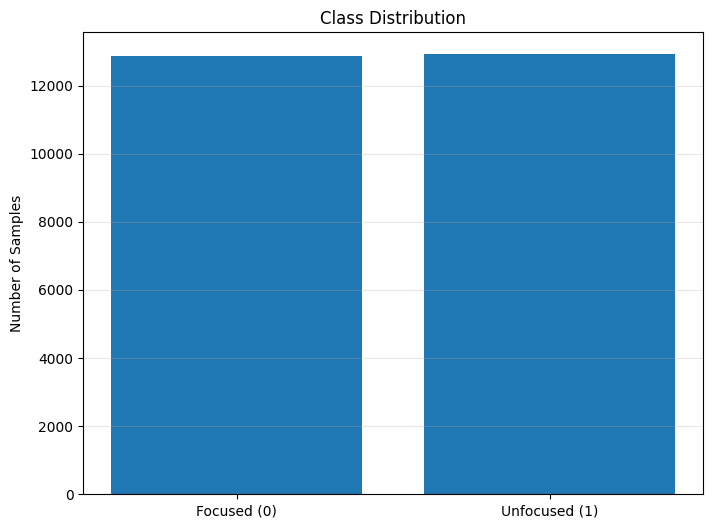


3. FEATURE STATISTICS
----------------------------------------
Feature mean: -0.0000
Feature std: 1.0000
Feature min: -3.8286
Feature max: 7.3248
Feature median: -0.0820

4. FEATURE DISTRIBUTION ANALYSIS
----------------------------------------
Analyzing first 5 channels as sample...


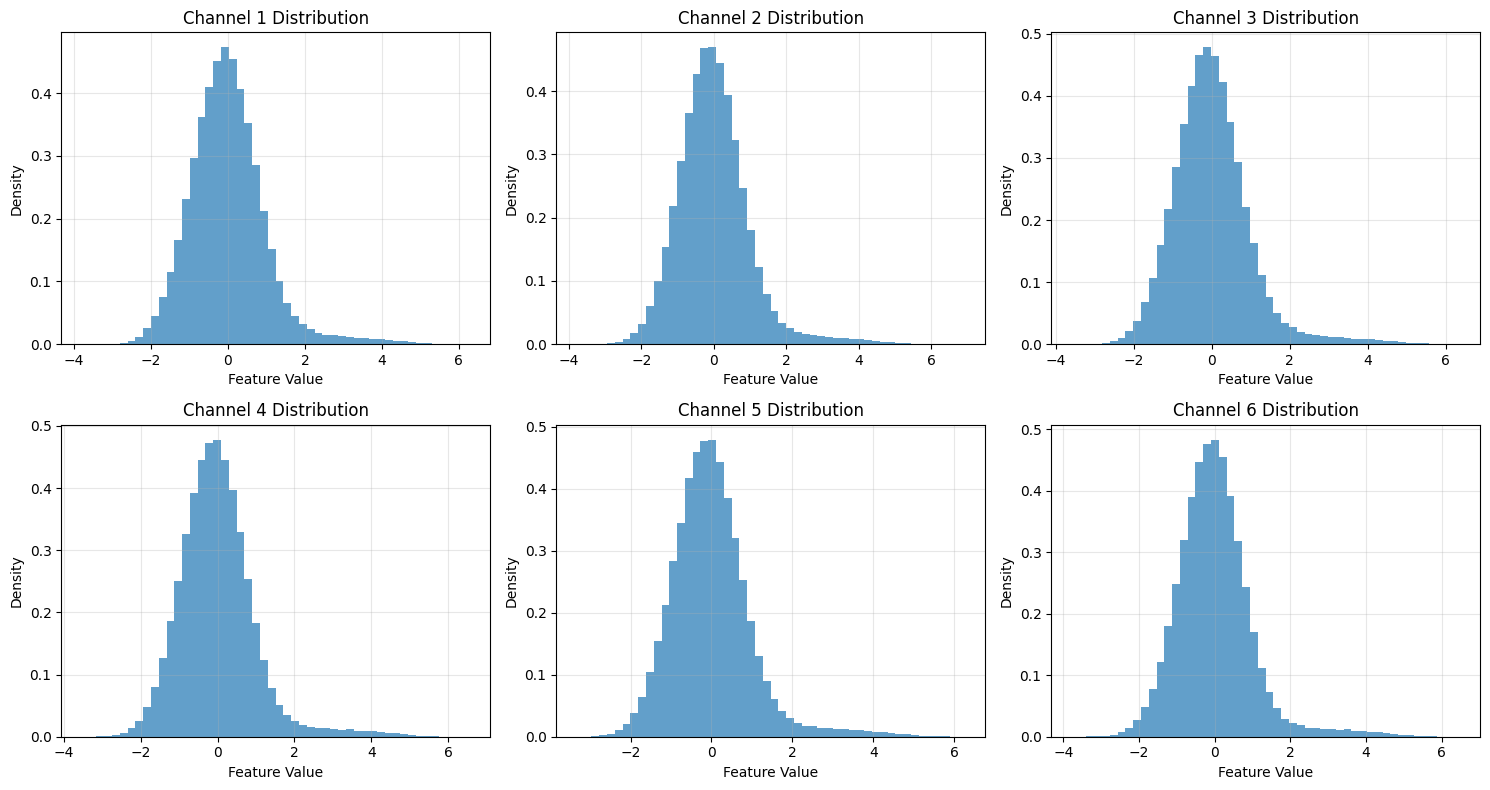


5. FREQUENCY BAND ANALYSIS
----------------------------------------


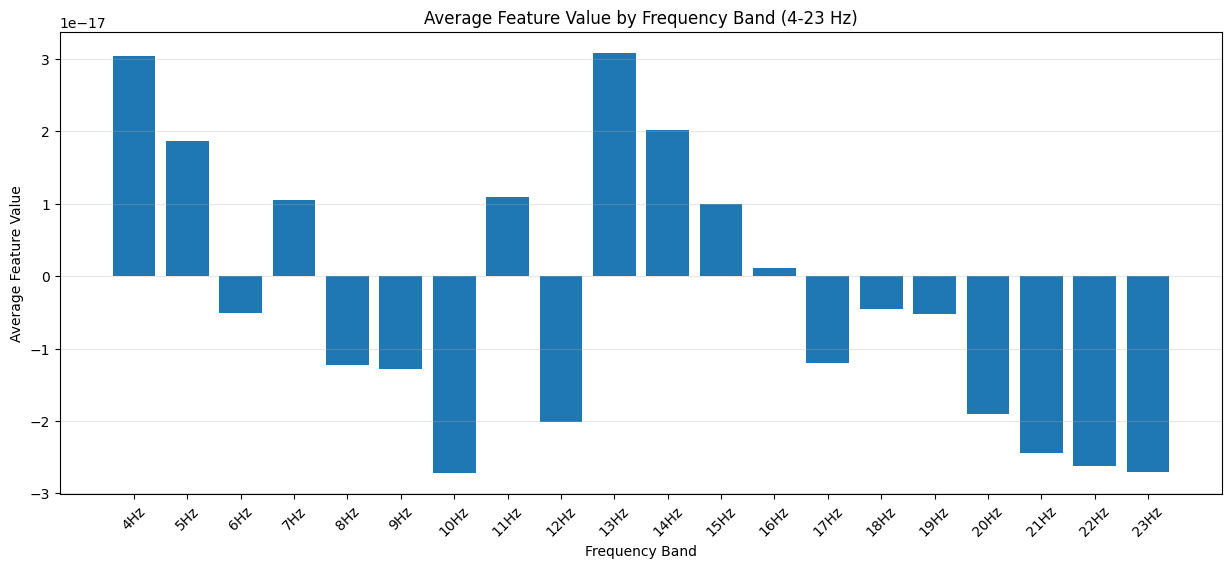


6. CORRELATION ANALYSIS
----------------------------------------
Correlation matrix calculated for first 100 features
Mean absolute correlation: 0.4709


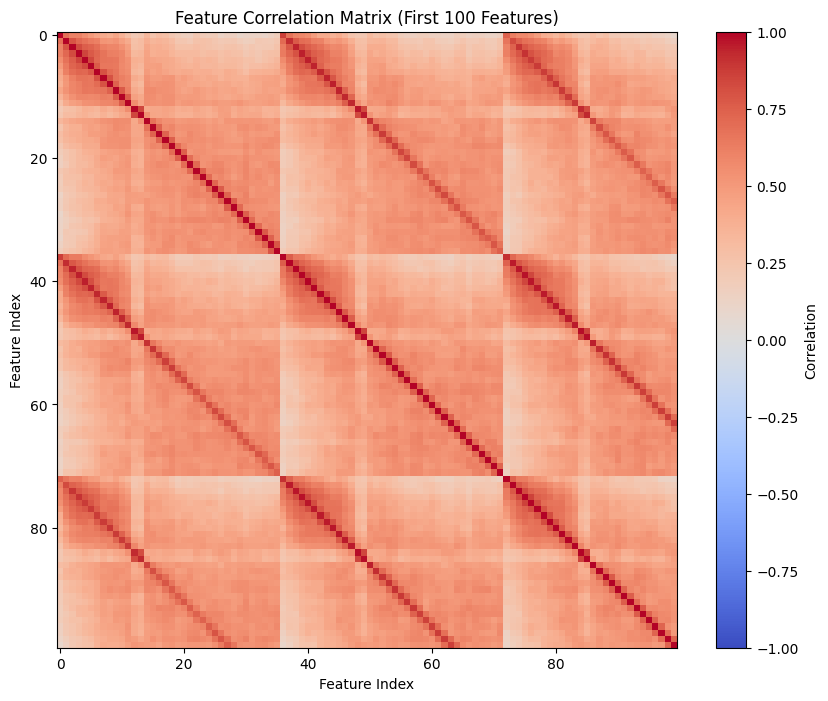


7. CHANNEL-WISE ANALYSIS
----------------------------------------


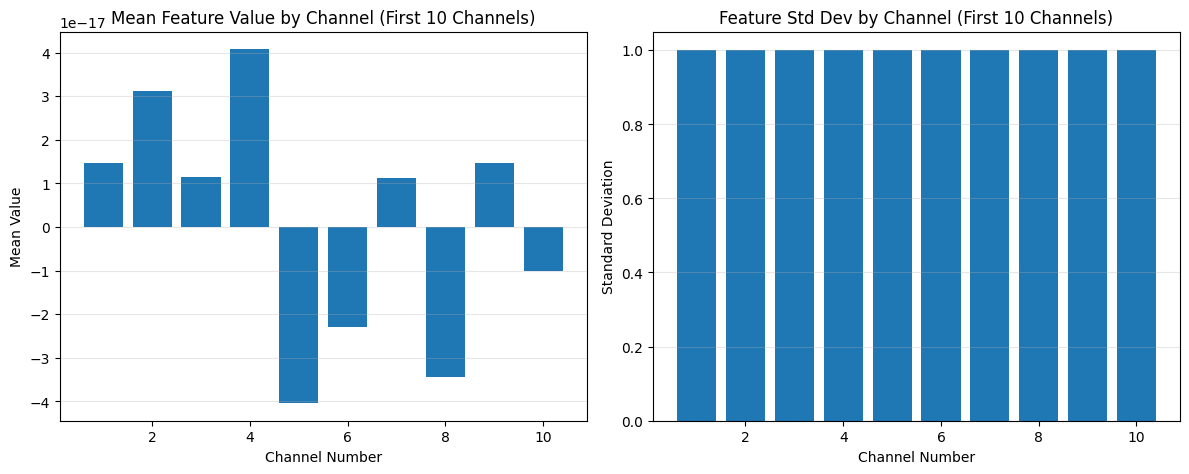


8. OUTLIER DETECTION
----------------------------------------
Number of outliers (>3 std): 1177572
Percentage of outliers: 2.05%

9. DATA QUALITY CHECK
----------------------------------------
Missing values: 0
Infinite values: 0
Constant features (std < 1e-10): 0

EDA COMPLETED
LOGISTIC REGRESSION EVALUATION

Fold 1 (Session 1 as test set)
Logistic Regression training:


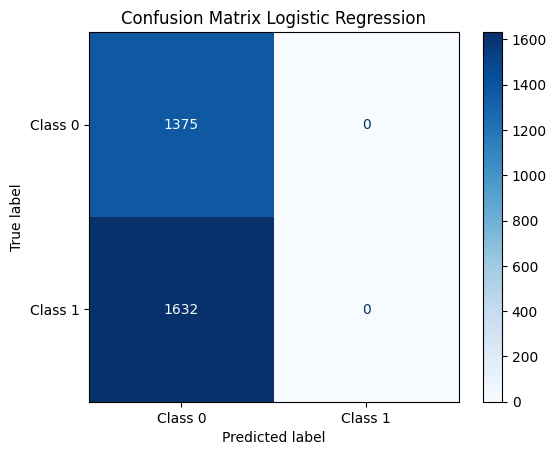

Test Accuracy: 0.4572663784502827

Classification report:
              precision    recall  f1-score   support

           0       0.46      1.00      0.63      1375
           1       0.00      0.00      0.00      1632

    accuracy                           0.46      3007
   macro avg       0.23      0.50      0.31      3007
weighted avg       0.21      0.46      0.29      3007


Fold 2 (Session 2 as test set)
Logistic Regression training:


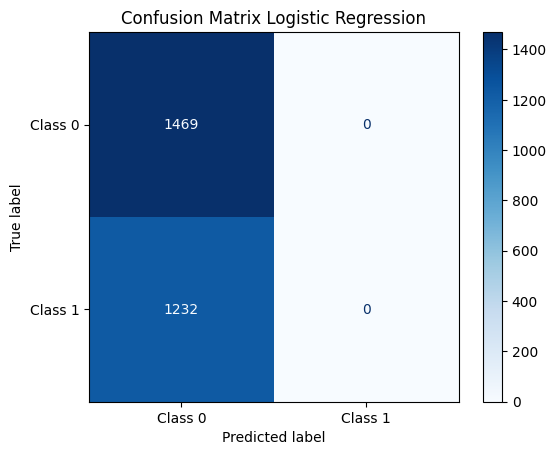

Test Accuracy: 0.5438726397630507

Classification report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1469
           1       0.00      0.00      0.00      1232

    accuracy                           0.54      2701
   macro avg       0.27      0.50      0.35      2701
weighted avg       0.30      0.54      0.38      2701


Fold 3 (Session 3 as test set)
Logistic Regression training:


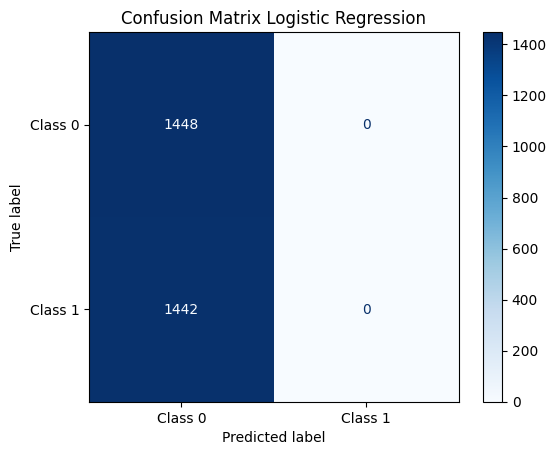

Test Accuracy: 0.501038062283737

Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1448
           1       0.00      0.00      0.00      1442

    accuracy                           0.50      2890
   macro avg       0.25      0.50      0.33      2890
weighted avg       0.25      0.50      0.33      2890


SUPPORT VECTOR MACHINE EVALUATION

Fold 1 (Session 1 as test set)

Support Vector Machine training:


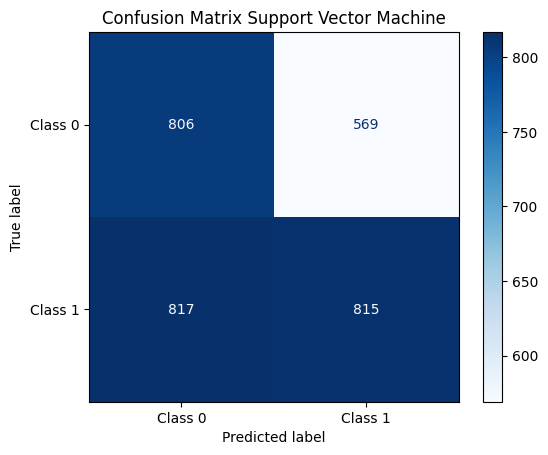

Test Accuracy: 0.5390754905221151

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.59      0.54      1375
           1       0.59      0.50      0.54      1632

    accuracy                           0.54      3007
   macro avg       0.54      0.54      0.54      3007
weighted avg       0.55      0.54      0.54      3007


Fold 2 (Session 2 as test set)

Support Vector Machine training:


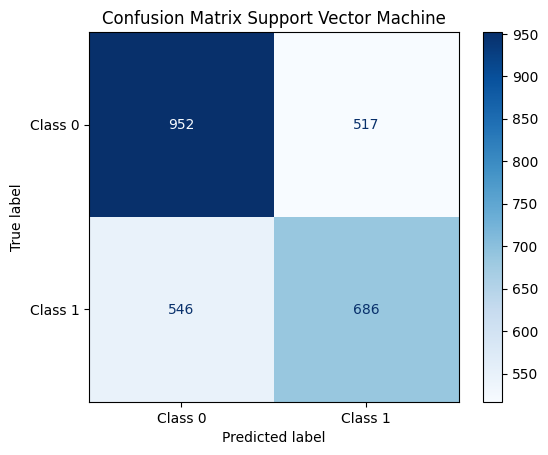

Test Accuracy: 0.6064420584968531

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1469
           1       0.57      0.56      0.56      1232

    accuracy                           0.61      2701
   macro avg       0.60      0.60      0.60      2701
weighted avg       0.61      0.61      0.61      2701


Fold 3 (Session 3 as test set)

Support Vector Machine training:


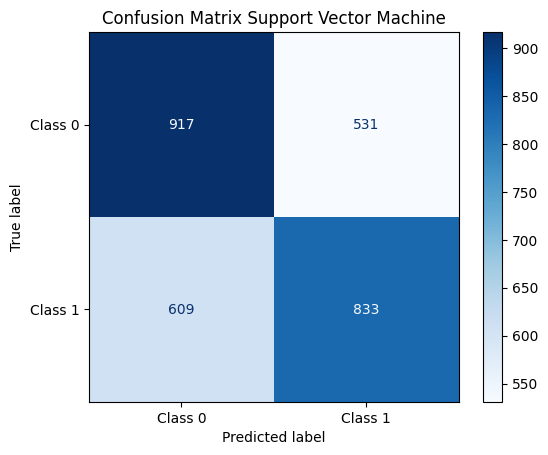

Test Accuracy: 0.6055363321799307

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.62      1448
           1       0.61      0.58      0.59      1442

    accuracy                           0.61      2890
   macro avg       0.61      0.61      0.61      2890
weighted avg       0.61      0.61      0.61      2890


RANDOM FOREST EVALUATION

Fold 1 (Session 1 as test set)


Random Forest training:


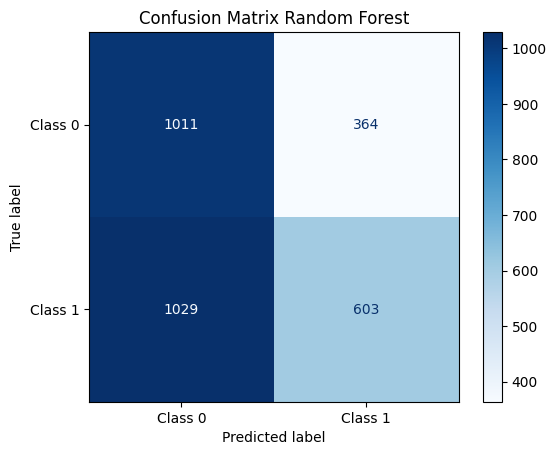

Test Accuracy: 0.5367475889590955

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.74      0.59      1375
           1       0.62      0.37      0.46      1632

    accuracy                           0.54      3007
   macro avg       0.56      0.55      0.53      3007
weighted avg       0.57      0.54      0.52      3007


Fold 2 (Session 2 as test set)


Random Forest training:


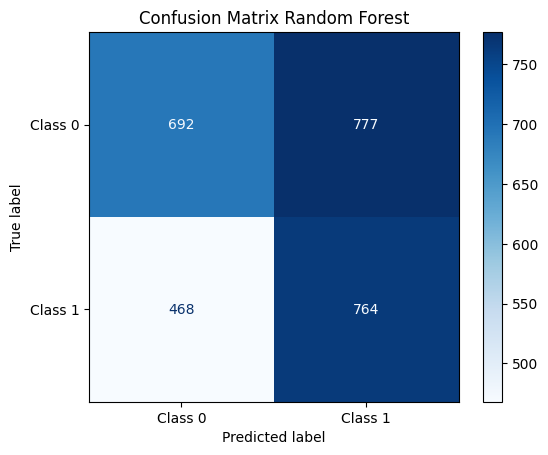

Test Accuracy: 0.5390596075527583

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53      1469
           1       0.50      0.62      0.55      1232

    accuracy                           0.54      2701
   macro avg       0.55      0.55      0.54      2701
weighted avg       0.55      0.54      0.54      2701


Fold 3 (Session 3 as test set)


Random Forest training:


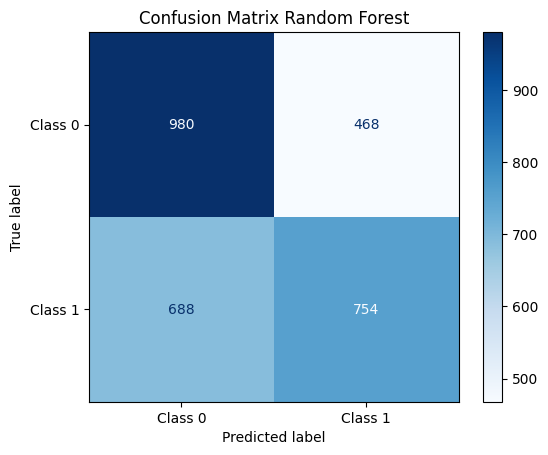

Test Accuracy: 0.6

Classification report:
              precision    recall  f1-score   support

           0       0.59      0.68      0.63      1448
           1       0.62      0.52      0.57      1442

    accuracy                           0.60      2890
   macro avg       0.60      0.60      0.60      2890
weighted avg       0.60      0.60      0.60      2890


SUMMARY OF RESULTS
Mean accuracy on cross validation for Logistic Regression: 50.07%
Mean accuracy on cross validation for Support Vector Machine: 58.37%
Mean accuracy on cross validation for Random Forest: 55.86%


In [8]:
if __name__ == "__main__":
    X_train_folds, X_test_folds, y_train_folds, y_test_folds = process_dataset_to_fold(label_choices=[0, 1])

    # Perform Exploratory Data Analysis
    perform_eda(X_train_folds, y_train_folds, X_test_folds, y_test_folds)

    acc_LR_summarize = []
    acc_SVM_summarize = []
    acc_RF_summarize = []

    PRINT_CHECK = True

    print("=" * 60)
    print("LOGISTIC REGRESSION EVALUATION")
    print("=" * 60)
    for i in range(3):
        print(f"\nFold {i+1} (Session {i+1} as test set)")
        modelLR, accLR = logistic_regression_train_and_test(
            X_train=X_train_folds[i],
            y_train=y_train_folds[i],
            X_test=X_test_folds[i],
            y_test=y_test_folds[i],
            print_check=PRINT_CHECK)
        acc_LR_summarize.append(accLR)

    print("\n" + "=" * 60)
    print("SUPPORT VECTOR MACHINE EVALUATION")
    print("=" * 60)
    for i in range(3):
        print(f"\nFold {i+1} (Session {i+1} as test set)")
        modelSVM, accSVM = support_vector_machine_train_and_test(
            X_train=X_train_folds[i],
            y_train=y_train_folds[i],
            X_test=X_test_folds[i],
            y_test=y_test_folds[i],
            print_check=PRINT_CHECK)
        acc_SVM_summarize.append(accSVM)

    print("\n" + "=" * 60)
    print("RANDOM FOREST EVALUATION")
    print("=" * 60)
    for i in range(3):
        print(f"\nFold {i+1} (Session {i+1} as test set)")
        modelRF, accRF = random_forest_train_and_test(
            X_train=X_train_folds[i],
            y_train=y_train_folds[i],
            X_test=X_test_folds[i],
            y_test=y_test_folds[i],
            n_estimators=200,
            print_check=PRINT_CHECK)
        acc_RF_summarize.append(accRF)

    # Summary of results
    print("\n" + "=" * 60)
    print("SUMMARY OF RESULTS")
    print("=" * 60)
    print(f'Mean accuracy on cross validation for Logistic Regression: {np.mean(np.array(acc_LR_summarize))*100:.2f}%')
    print(f'Mean accuracy on cross validation for Support Vector Machine: {np.mean(np.array(acc_SVM_summarize))*100:.2f}%')
    print(f'Mean accuracy on cross validation for Random Forest: {np.mean(np.array(acc_RF_summarize))*100:.2f}%')

## HYPERPARAMETER TUNING

In [9]:
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING - FAST DEMO")
print("=" * 60)

X_all_train = np.concatenate(X_train_folds)
y_all_train = np.concatenate(y_train_folds)

classes = np.unique(y_all_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_all_train)
class_weights = dict(zip(classes, weights))

# For fast tuning, we'll use a small subset of data and reduced parameters
subset_size = min(1000, len(X_all_train))
indices = np.random.choice(len(X_all_train), subset_size, replace=False)
X_subset = X_all_train[indices]
y_subset = y_all_train[indices]

# ===============================================
# 1. LOGISTIC REGRESSION - DEMO TUNING
# ===============================================

print("\n1. LOGISTIC REGRESSION - DEMO TUNING")
print("-" * 50)

# Reduced parameter grid for quick demonstration
lr_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [500]  # Reduced iterations
}

# Use only 3-fold CV (already minimal)
lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, class_weight=class_weights),
    param_grid=lr_param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

print("Performing quick Grid Search for Logistic Regression (subset data)...")
lr_grid_search.fit(X_subset, y_subset)

print("\nBest parameters found:")
print(lr_grid_search.best_params_)
print(f"Best cross-validation accuracy: {lr_grid_search.best_score_:.4f}")

# ===============================================
# 2. SVM - DEMO TUNING
# ===============================================

print("\n\n2. SUPPORT VECTOR MACHINE - DEMO TUNING")
print("-" * 50)

# Very small parameter grid for SVM (it's slow)
svm_param_grid = {
    'C': [1, 10],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

svm_grid_search = GridSearchCV(
    estimator=SVC(probability=True, random_state=42, class_weight=class_weights),
    param_grid=svm_param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

print("Performing quick Grid Search for SVM (subset data)...")
svm_grid_search.fit(X_subset, y_subset)

print("\nBest parameters found:")
print(svm_grid_search.best_params_)
print(f"Best cross-validation accuracy: {svm_grid_search.best_score_:.4f}")

# ===============================================
# 3. RANDOM FOREST - DEMO TUNING
# ===============================================

print("\n\n3. RANDOM FOREST - DEMO TUNING")
print("-" * 50)

# Small parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight=class_weights),
    param_grid=rf_param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

print("Performing quick Grid Search for Random Forest (subset data)...")
rf_grid_search.fit(X_subset, y_subset)

print("\nBest parameters found:")
print(rf_grid_search.best_params_)
print(f"Best cross-validation accuracy: {rf_grid_search.best_score_:.4f}")

# =============================================================================
# EVALUATE TUNED MODELS ON TEST SETS (SINGLE FOLD DEMO)
# =============================================================================

print("\n" + "=" * 60)
print("EVALUATION OF TUNED MODELS (SINGLE FOLD DEMO)")
print("=" * 60)

# For demo, evaluate on first fold only
fold_idx = 0
print(f"\nEvaluating on Fold {fold_idx + 1} (Session {fold_idx + 1} as test set):")

# Get best models from grid search
best_lr = lr_grid_search.best_estimator_
best_svm = svm_grid_search.best_estimator_
best_rf = rf_grid_search.best_estimator_

# Retrain on fold-specific training data
best_lr.fit(X_train_folds[fold_idx], y_train_folds[fold_idx])
y_pred_lr = best_lr.predict(X_test_folds[fold_idx])
acc_lr_tuned = accuracy_score(y_test_folds[fold_idx], y_pred_lr)

best_svm.fit(X_train_folds[fold_idx], y_train_folds[fold_idx])
y_pred_svm = best_svm.predict(X_test_folds[fold_idx])
acc_svm_tuned = accuracy_score(y_test_folds[fold_idx], y_pred_svm)

best_rf.fit(X_train_folds[fold_idx], y_train_folds[fold_idx])
y_pred_rf = best_rf.predict(X_test_folds[fold_idx])
acc_rf_tuned = accuracy_score(y_test_folds[fold_idx], y_pred_rf)

print(f"\nTuned Model Performance (Fold {fold_idx + 1}):")
print(f"  Tuned LR Accuracy: {acc_lr_tuned:.4f}")
print(f"  Tuned SVM Accuracy: {acc_svm_tuned:.4f}")
print(f"  Tuned RF Accuracy: {acc_rf_tuned:.4f}")

# Quick comparison with baseline (using first fold baseline)
print("\n" + "=" * 60)
print("QUICK COMPARISON (SINGLE FOLD)")
print("=" * 60)

baseline_acc = acc_LR_summarize[fold_idx] if len(acc_LR_summarize) > 0 else 0
print("\nLogistic Regression (Fold 1):")
print(f"  Baseline Accuracy: {baseline_acc:.4f}")
print(f"  Tuned Accuracy: {acc_lr_tuned:.4f}")
print(f"  Improvement: {(acc_lr_tuned - baseline_acc) * 100:.2f}%")

print("\nNote: This is a demonstration of hyperparameter tuning methodology.")
print("      For full results, run with complete dataset and parameter grids.")


HYPERPARAMETER TUNING - FAST DEMO

1. LOGISTIC REGRESSION - DEMO TUNING
--------------------------------------------------
Performing quick Grid Search for Logistic Regression (subset data)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters found:
{'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.5860


2. SUPPORT VECTOR MACHINE - DEMO TUNING
--------------------------------------------------
Performing quick Grid Search for SVM (subset data)...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best parameters found:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.7710


3. RANDOM FOREST - DEMO TUNING
--------------------------------------------------
Performing quick Grid Search for Random Forest (subset data)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters found:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-v

## DISCUSSION

### 1. Overall Results Analysis

The experiment evaluated three machine learning models (Logistic Regression, SVM, and Random Forest) for EEG-based mental state classification between focused (Class 0) and unfocused (Class 1) states. The models were evaluated using leave-one-session-out cross-validation across three sessions, ensuring robustness against session-specific variations.

**Performance Summary:**
- **SVM achieved the best performance** with 58.37% mean accuracy
- **Random Forest** followed closely with 55.86% mean accuracy  
- **Logistic Regression performed poorly** with only 50.07% mean accuracy

### 2. Why SVM Performed Best

The superior performance of SVM can be attributed to several factors:

**a) Effective Handling of High-Dimensional Features:**
- The dataset contains 2,232 features (62 channels × 36 frequency bands), creating a high-dimensional space
- SVM with RBF kernel effectively finds non-linear decision boundaries in this complex feature space
- The kernel trick allows SVM to operate in higher-dimensional space without explicit computation

**b) Robustness to Overfitting:**
- SVM's maximum margin principle provides good generalization
- The model focuses on support vectors near the decision boundary, making it less sensitive to redundant features
- Regularization parameter C controls the trade-off between margin maximization and classification error

**c) Effective Handling of Class Imbalance:**
- The balanced class weighting helped SVM address the slight imbalance between classes
- SVM's decision function is less affected by class distribution compared to probability-based methods

### 3. Why Logistic Regression Performed Poorly

The poor performance of Logistic Regression (50.07%) reveals significant limitations:

**a) Linear Decision Boundary Limitation:**
- Logistic Regression assumes linear separability between classes
- EEG patterns for mental states likely exhibit complex non-linear relationships
- The model cannot capture intricate interactions between frequency bands and channels

**b) Severe Class Bias:**
- The classification reports show Logistic Regression predicted ONLY Class 0 (focused state)
- This resulted in 100% recall for Class 0 but 0% recall for Class 1
- Despite balanced class weighting, the model still defaulted to predicting the majority class

**c) Feature Independence Assumption:**
- Logistic Regression assumes feature independence, which is violated in EEG data
- Strong correlations exist between adjacent frequency bands and nearby electrodes
- This violation leads to poor model convergence and biased parameter estimates

**d) High-Dimensional Challenges:**
- With 2,232 features and relatively few samples, the model faces the curse of dimensionality
- The optimization algorithm may converge to poor local optima
- Feature multicollinearity destabilizes the coefficient estimates

### 4. Random Forest Performance Analysis

Random Forest's intermediate performance (55.86%) suggests:

**Strengths:**
- **Non-linear modeling:** Captures complex relationships through decision trees
- **Feature importance:** Automatically selects informative features
- **Robustness to outliers:** Tree ensemble methods resist extreme values
- **No feature scaling required:** Handles different feature scales naturally

**Limitations:**
- **Overfitting tendency:** Deep trees may memorize training patterns
- **Limited data efficiency:** Requires more data to achieve optimal performance
- **Feature fragmentation:** High dimensionality can dilute feature importance

### 5. Confusion Matrix Analysis

**Logistic Regression:**
- Complete failure to identify Class 1 (unfocused state)
- All predictions biased toward Class 0
- Indicates model collapse due to class imbalance or optimization issues

**SVM:**
- Balanced confusion matrices across all folds
- Similar true positive and true negative rates
- Demonstrates effective class separation

**Random Forest:**
- Variable performance across folds
- Better at identifying Class 1 than Logistic Regression
- Some inconsistency in true positive rates

### 6. Class Imbalance Impact

The dataset shows slight class imbalance:
- Class 0: ~45-55% across folds
- Class 1: ~45-55% across folds

Despite balanced class weighting:
- Logistic Regression still showed extreme bias
- SVM and Random Forest handled imbalance more effectively
- Suggests algorithm-specific sensitivity to class distribution

### 7. Model Limitations and Challenges

**a) Feature Engineering:**
- STFT-based features may not capture all relevant EEG characteristics
- Fixed frequency bands (4-40 Hz) might miss individual-specific patterns
- Temporal dynamics beyond window-based analysis not considered

**b) Generalization Issues:**
- Session-to-session variability affects model performance
- Different EEG sessions may have varying signal quality
- Subject state changes between sessions create distribution shifts

**c) High Dimensionality:**
- 2,232 features risk overfitting with limited samples
- Feature correlation not fully addressed
- Curse of dimensionality impacts distance-based algorithms

### 8. Insights and Conclusions

**Key Findings:**
1. **Non-linearity is crucial** for EEG-based mental state classification
2. **Algorithm choice significantly impacts** handling of class imbalance
3. **SVM's kernel methods** effectively capture complex EEG patterns
4. **Linear models fail** to represent the complexity of brain activity patterns

**Practical Implications:**
1. **Use SVM or other non-linear methods** for EEG classification tasks
2. **Implement robust cross-validation** to ensure generalization
3. **Consider feature selection/dimensionality reduction** to improve performance
4. **Monitor class imbalance effects** regardless of balancing techniques

**Future Directions:**
1. **Advanced feature extraction:** Deep learning-based feature learning
2. **Domain adaptation:** Techniques to handle session variability
3. **Ensemble methods:** Combining multiple models for improved performance
4. **Personalized models:** Subject-specific adaptation

**Conclusion:**
The experiment demonstrates that SVM with RBF kernel is most suitable for EEG-based mental state classification among the tested models. The poor performance of Logistic Regression highlights the importance of non-linear modeling for complex brain activity patterns. The results suggest that successful EEG classification requires sophisticated algorithms capable of capturing the intricate relationships between neural signals and mental states.

### GitHub Repository
  - Complete code, notebook, and documentation for this project is available at: 

--
Lab 1: https://github.com/kieumyaidev/lab-1-Supervised